In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# import dataset
df = pd.read_csv("data/gold.csv")

In [10]:
df = df.drop(columns=['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               7043 non-null   object 
 1   SeniorCitizen        7043 non-null   object 
 2   Partner              7043 non-null   object 
 3   Dependents           7043 non-null   object 
 4   tenure               7043 non-null   int64  
 5   PhoneService         7043 non-null   object 
 6   MultipleLines        7043 non-null   object 
 7   InternetService      7043 non-null   object 
 8   Contract             7043 non-null   object 
 9   PaperlessBilling     7043 non-null   object 
 10  PaymentMethod        7043 non-null   object 
 11  MonthlyCharges       7043 non-null   float64
 12  TotalCharges         7043 non-null   float64
 13  Churn                7043 non-null   object 
 14  nb_service_internet  7043 non-null   int64  
dtypes: float64(2), int64(2), object(11)
me

In [11]:
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

In [12]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()


y_train =  labelencoder.fit_transform(y_train)

y_test = labelencoder.transform(y_test)

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

categorial_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
       'PhoneService', 'MultipleLines', 'InternetService','Contract', 'PaperlessBilling', 'PaymentMethod'
       ]

numerical_features = list(X.select_dtypes(include=[int,float]).columns)

categorical_transformer = OneHotEncoder(sparse=True)

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorial_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

log_reg = LogisticRegression(penalty='l2', C=0.01)

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', log_reg)
])

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(sparse=True),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'nb_service_internet'])])),
                ('log_reg', LogisticRegression(C=0.01))])

In [42]:

import mlflow

experiment_id = mlflow.set_experiment("churn_model").experiment_id

run_name = "reglog_C_small_stdscaler"

with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
    # Log the baseline model to MLflow
    pipe.fit(X_train, y_train)
    
    
    mlflow.sklearn.log_model(pipe, run_name)

    
    model_uri = mlflow.get_artifact_uri(run_name)

    # Log des paramètres

    mlflow.log_param("C",0.8)

    # Log des Tags
    mlflow.set_tag("model","logistic_regression")
    mlflow.set_tag("regularisation",True)

    eval_data = X_test
    eval_data["label"] = y_test

    # Evaluate the logged model
    result = mlflow.evaluate(
        model_uri,
        eval_data,
        targets="label",
        model_type="classifier",
        evaluators=["default"],
    )

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2023/05/12 11:07:14 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/05/12 11:07:14 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/05/12 11:07:15 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


In [36]:
y_pred_test = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)


In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
print("######## accuracy_score : ")
print("TRAIN :",accuracy_score(y_train, y_pred_train))
print("TEST :",accuracy_score(y_test, y_pred_test))

print("######## precision_score : ")
print("TRAIN :",precision_score(y_train, y_pred_train))
print("TEST :",precision_score(y_test, y_pred_test))

print("######## recall_score : ")    
print("TRAIN :",recall_score(y_train, y_pred_train))
print("TEST :",recall_score(y_test, y_pred_test))

print("######## f1_score : ")
print("TRAIN :",f1_score(y_train, y_pred_train))
print("TEST :",f1_score(y_test, y_pred_test))

######## accuracy_score : 
TRAIN : 0.8042243521476748
TEST : 0.8204400283889283
######## precision_score : 
TRAIN : 0.6609336609336609
TEST : 0.6829268292682927
######## recall_score : 
TRAIN : 0.5394385026737968
TEST : 0.6005361930294906
######## f1_score : 
TRAIN : 0.5940375414059625
TEST : 0.6390870185449358


<Figure size 1050x700 with 0 Axes>

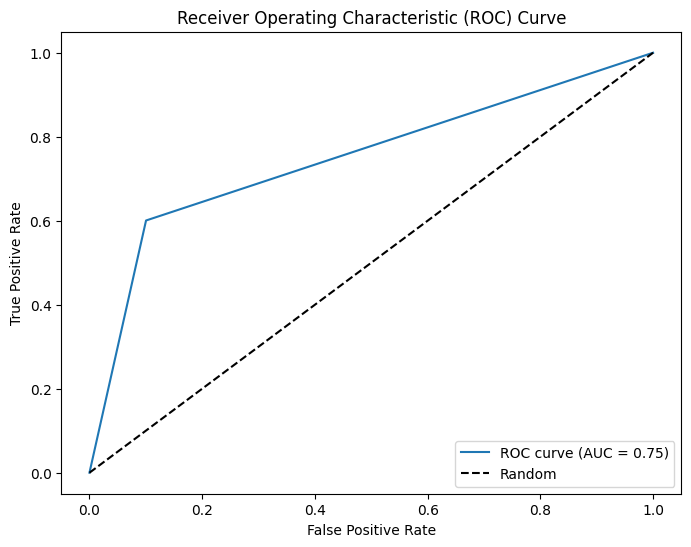

######## roc_auc_score : 
TRAIN : 0.7196950850730028
TEST : 0.7500750463216951


In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("######## roc_auc_score : ")    
print("TRAIN :",roc_auc_score(y_train, y_pred_train))
print("TEST :",roc_auc_score(y_test, y_pred_test))  

